In [215]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns

In [216]:
df = pd.read_excel('/content/Analyst case study dataset 1.xls')

In [217]:
df.dtypes

,0
LeadCreated,datetime64[ns]
FirstName,object
Email,object
VendorLeadID,object
CallStatus,object
WidgetName,object
PublisherZoneName,object
PublisherCampaignName,object
AddressScore,float64
PhoneScore,float64


In [218]:
df.nunique()

,0
LeadCreated,2786
FirstName,1695
Email,2888
VendorLeadID,3012
CallStatus,7
WidgetName,14
PublisherZoneName,2
PublisherCampaignName,2
AddressScore,5
PhoneScore,5


In [219]:
df['CallStatus'] = df['CallStatus'].fillna('Unknown')
df['Month'] = df['LeadCreated'].dt.to_period('M')
df['LeadQuality'] = df['CallStatus'].apply(lambda x: 'Unknown' if x == 'Unknown'
                                           else 'Good' if x in ['Closed', 'EP Confirmed', 'EP Received', 'EP Sent']
                                           else 'Bad')
df['Partner'] = df['Partner'].str.lower()

In [220]:
print(df['CallStatus'].isna().sum())  # Count missing values
print(df['CallStatus'].unique())
print(df['LeadQuality'].isna().sum())  # Count missing values
print(df['LeadQuality'].unique())

0
['Unknown' 'Unable to contact - Bad Contact Information'
 "Contacted - Doesn't Qualify" 'Closed' 'EP Received' 'EP Confirmed'
 'Contacted - Invalid Profile' 'EP Sent']
0
['Unknown' 'Bad' 'Good']


In [221]:
def split_debt_level(debt_str):
    if debt_str == 'More_than_100000':
        return (100000, float('inf'))

    # Split the range and convert to numbers
    min_val, max_val = debt_str.split('-')
    return (float(min_val), float(max_val))

# Create new columns by applying the function
df[['DebtLevel_Min', 'DebtLevel_Max']] = df['DebtLevel'].apply(split_debt_level).apply(pd.Series)

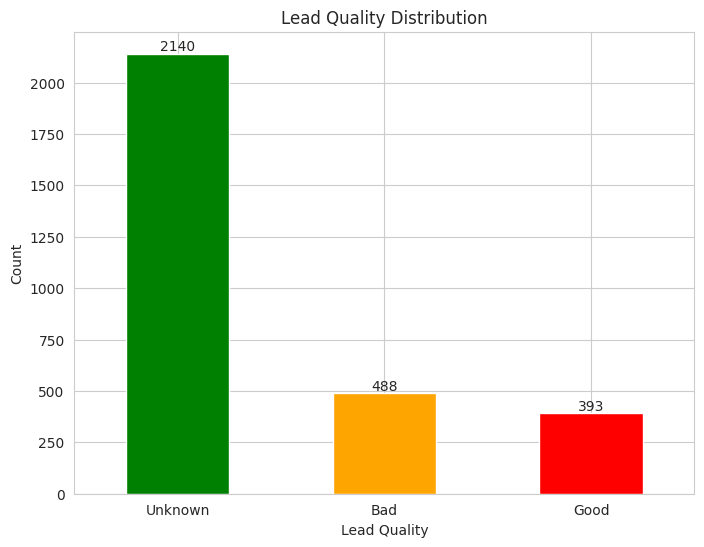

In [222]:
lead_quality_counts = df['LeadQuality'].value_counts()

# Create the bar plot
plt.figure(figsize=(8, 6))
ax = lead_quality_counts.plot(kind='bar', color=['green', 'orange', 'red'])

# Add labels and title
plt.title('Lead Quality Distribution')
plt.xlabel('Lead Quality')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Add numbers on top of the bars
for i, v in enumerate(lead_quality_counts):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom')

# Show the plot
plt.show()

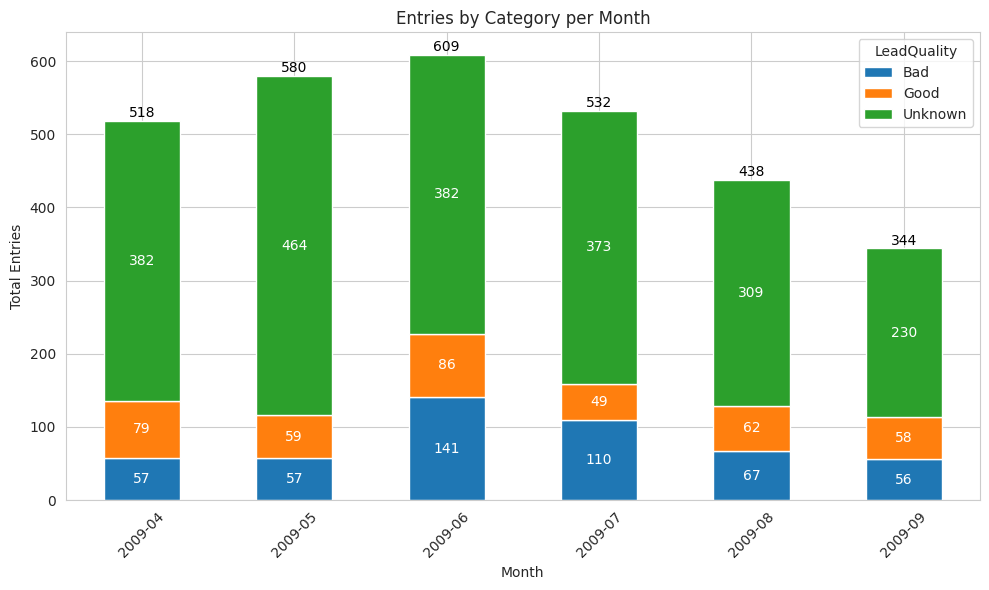

In [223]:
count_df = df.groupby(['Month', 'LeadQuality']).size().unstack(fill_value=0)

# Plotting the stacked bar chart
ax = count_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add counts inside each section of the bars
for p in ax.patches:
    height = p.get_height()  # Get the height of each section
    width = p.get_width()  # Get the width of each section
    x = p.get_x() + width / 2  # Get the x position (center of the section)
    y = p.get_y() + height / 2  # Get the y position (center of the section)

    # Place the count value inside the section
    ax.text(x, y, str(int(height)), ha='center', va='center', color='white')

# Add total count above each bar
totals = count_df.sum(axis=1)  # Get total counts for each month
for i, total in enumerate(totals):
    ax.text(i, total + 1, str(total), ha='center', va='bottom', color='black')

# Set labels and title
plt.title('Entries by Category per Month')
plt.xlabel('Month')
plt.ylabel('Total Entries')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

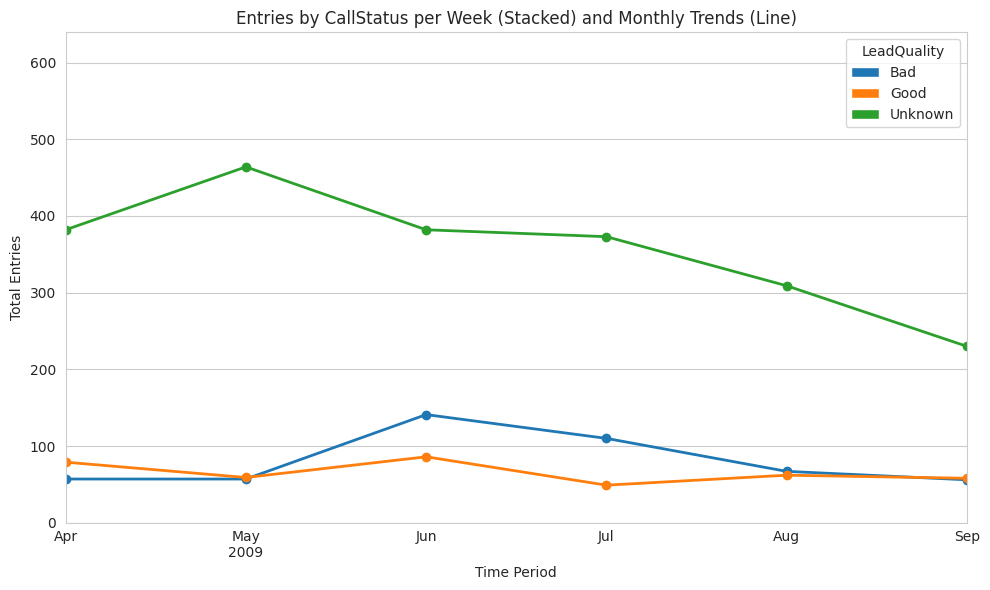

In [224]:
count_df_monthly = df.groupby(['Month', 'LeadQuality']).size().unstack(fill_value=0)

# Plotting the weekly stacked bar chart
ax = count_df_monthly.plot(kind='bar', stacked=True, figsize=(10, 6), position=1)

# Filter out 'Unknown' category for the monthly line graph
df_filtered = df

# Group by 'Month' and 'CallStatus', and count the entries for the line graph
count_df_monthly = df_filtered.groupby(['Month', 'LeadQuality']).size().unstack(fill_value=0)

# Plotting the line graph for monthly trend of each category (excluding 'Unknown')
for category in count_df_monthly.columns:
    count_df_monthly[category].plot(kind='line', ax=ax, marker='o', label=f'{category} (monthly trend)', linestyle='-', linewidth=2)

# Set labels and title
plt.title('Entries by CallStatus per Week (Stacked) and Monthly Trends (Line)')
plt.xlabel('Time Period')
plt.ylabel('Total Entries')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)



# Make sure the layout is tight
plt.tight_layout()

# Show the plot
plt.show()


LeadQuality    Month  Good Lead Percentage
0            2009-04             15.250965
1            2009-05             10.172414
2            2009-06             14.121511
3            2009-07              9.210526
4            2009-08             14.155251
5            2009-09             16.860465


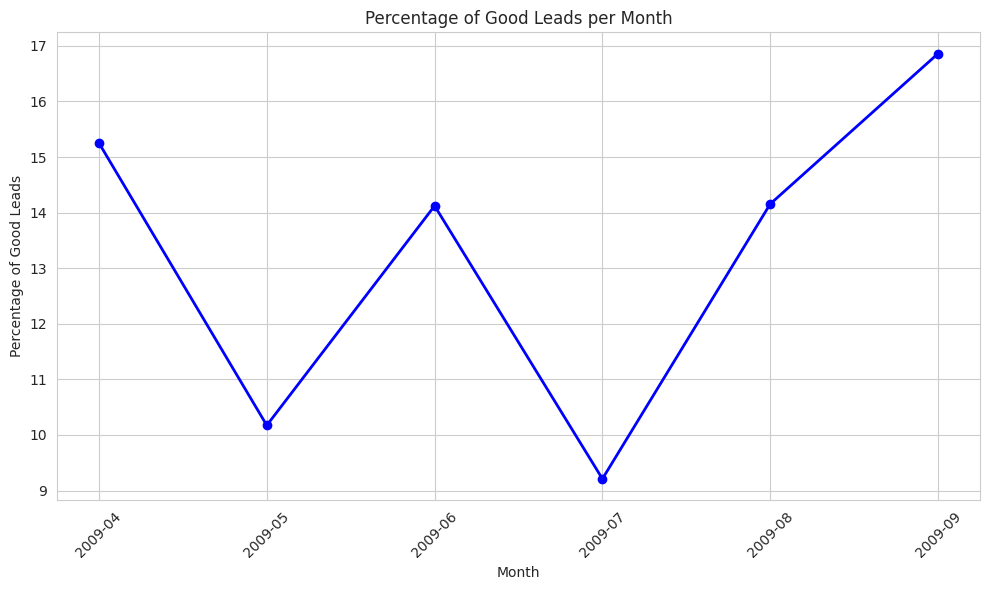

In [225]:
# Group by Month and LeadQuality, then count occurrences
monthly_counts = df.groupby(['Month', 'LeadQuality']).size().unstack(fill_value=0)

# Reset index to ensure 'Month' remains a column
monthly_counts = monthly_counts.reset_index()

# Calculate the percentage of Good Quality Leads safely
monthly_counts['Good Lead Percentage'] = (monthly_counts.get('Good', 0) / monthly_counts.iloc[:, 1:].sum(axis=1)) * 100

# Display the result
print(monthly_counts[['Month', 'Good Lead Percentage']])

# Plot the percentage of Good Leads as a line graph
plt.figure(figsize=(10, 6))
plt.plot(monthly_counts['Month'].astype(str), monthly_counts['Good Lead Percentage'], marker='o', color='b', linestyle='-', linewidth=2)

# Set the title and labels
plt.title('Percentage of Good Leads per Month')
plt.xlabel('Month')
plt.ylabel('Percentage of Good Leads')
plt.xticks(rotation=45)
plt.grid(True)  # Add a grid for better readability
plt.tight_layout()

# Show the plot
plt.show()


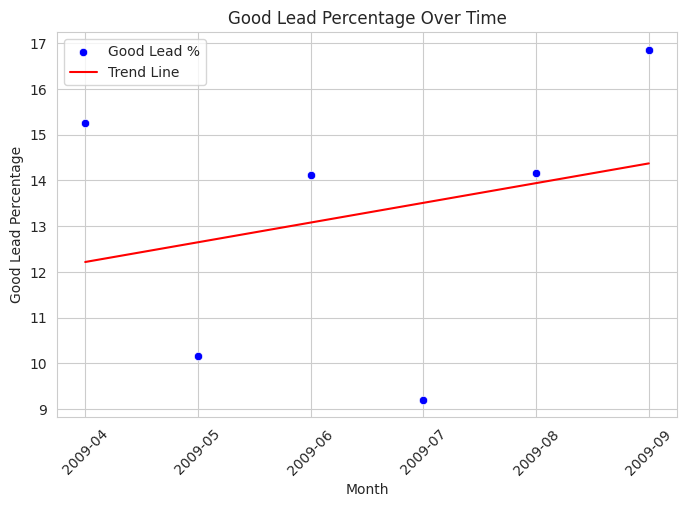

Trend Slope: 0.4310
P-Value: 0.6040


In [226]:
# Ensure 'Month' is in datetime format
monthly_counts['Month'] = monthly_counts['Month'].dt.to_timestamp()

# Sort by Month to maintain chronological order
monthly_counts = monthly_counts.sort_values(by='Month')

# Create a numerical representation of months for regression
monthly_counts["Month_Num"] = np.arange(len(monthly_counts))

# Define X and y for regression
X = sm.add_constant(monthly_counts["Month_Num"])  # Add constant for intercept
y = monthly_counts["Good Lead Percentage"]

# Check for missing values
if y.isnull().any():
    print("Warning: Missing values detected in Good Lead Percentage. Filling with 0.")
    y = y.fillna(0)

# Perform linear regression
model = sm.OLS(y, X).fit()

# Extract slope and p-value
trend_slope = model.params["Month_Num"]
p_value = model.pvalues["Month_Num"]

# Plot the data with trend line
plt.figure(figsize=(8, 5))
sns.scatterplot(x=monthly_counts["Month_Num"], y=monthly_counts["Good Lead Percentage"], label="Good Lead %", color="b")
sns.lineplot(x=monthly_counts["Month_Num"], y=model.predict(X), label="Trend Line", color="r")

# Format x-axis labels
plt.xticks(ticks=monthly_counts["Month_Num"], labels=monthly_counts["Month"].dt.strftime('%Y-%m'), rotation=45)

# Set labels and title
plt.xlabel("Month")
plt.ylabel("Good Lead Percentage")
plt.title("Good Lead Percentage Over Time")
plt.legend()
plt.show()

# Print regression results
print(f"Trend Slope: {trend_slope:.4f}")
print(f"P-Value: {p_value:.4f}")


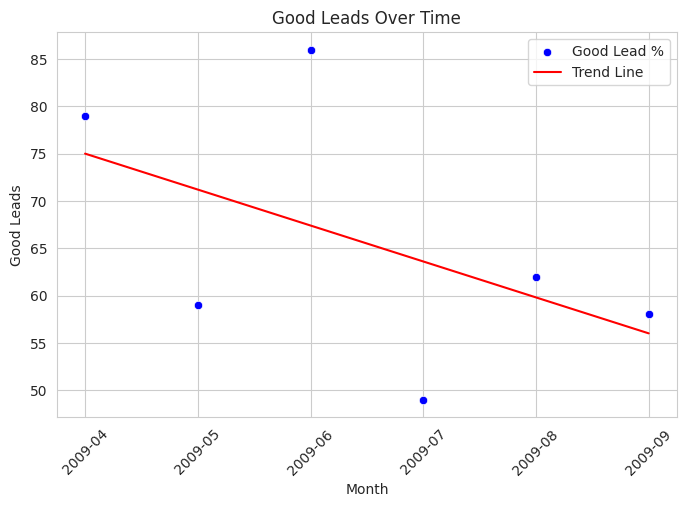

Trend Slope: -3.8000
P-Value: 0.3054


In [227]:
# Define X and y for regression
X = sm.add_constant(monthly_counts["Month_Num"])  # Add constant for intercept
y = monthly_counts["Good"]

# Check for missing values
if y.isnull().any():
    print("Warning: Missing values detected in Good Lead Percentage. Filling with 0.")
    y = y.fillna(0)

# Perform linear regression
model = sm.OLS(y, X).fit()

# Extract slope and p-value
trend_slope = model.params["Month_Num"]
p_value = model.pvalues["Month_Num"]

# Plot the data with trend line
plt.figure(figsize=(8, 5))
sns.scatterplot(x=monthly_counts["Month_Num"], y=monthly_counts["Good"], label="Good Lead %", color="b")
sns.lineplot(x=monthly_counts["Month_Num"], y=model.predict(X), label="Trend Line", color="r")

# Format x-axis labels
plt.xticks(ticks=monthly_counts["Month_Num"], labels=monthly_counts["Month"].dt.strftime('%Y-%m'), rotation=45)

# Set labels and title
plt.xlabel("Month")
plt.ylabel("Good Leads")
plt.title("Good Leads Over Time")
plt.legend()
plt.show()

# Print regression results
print(f"Trend Slope: {trend_slope:.4f}")
print(f"P-Value: {p_value:.4f}")


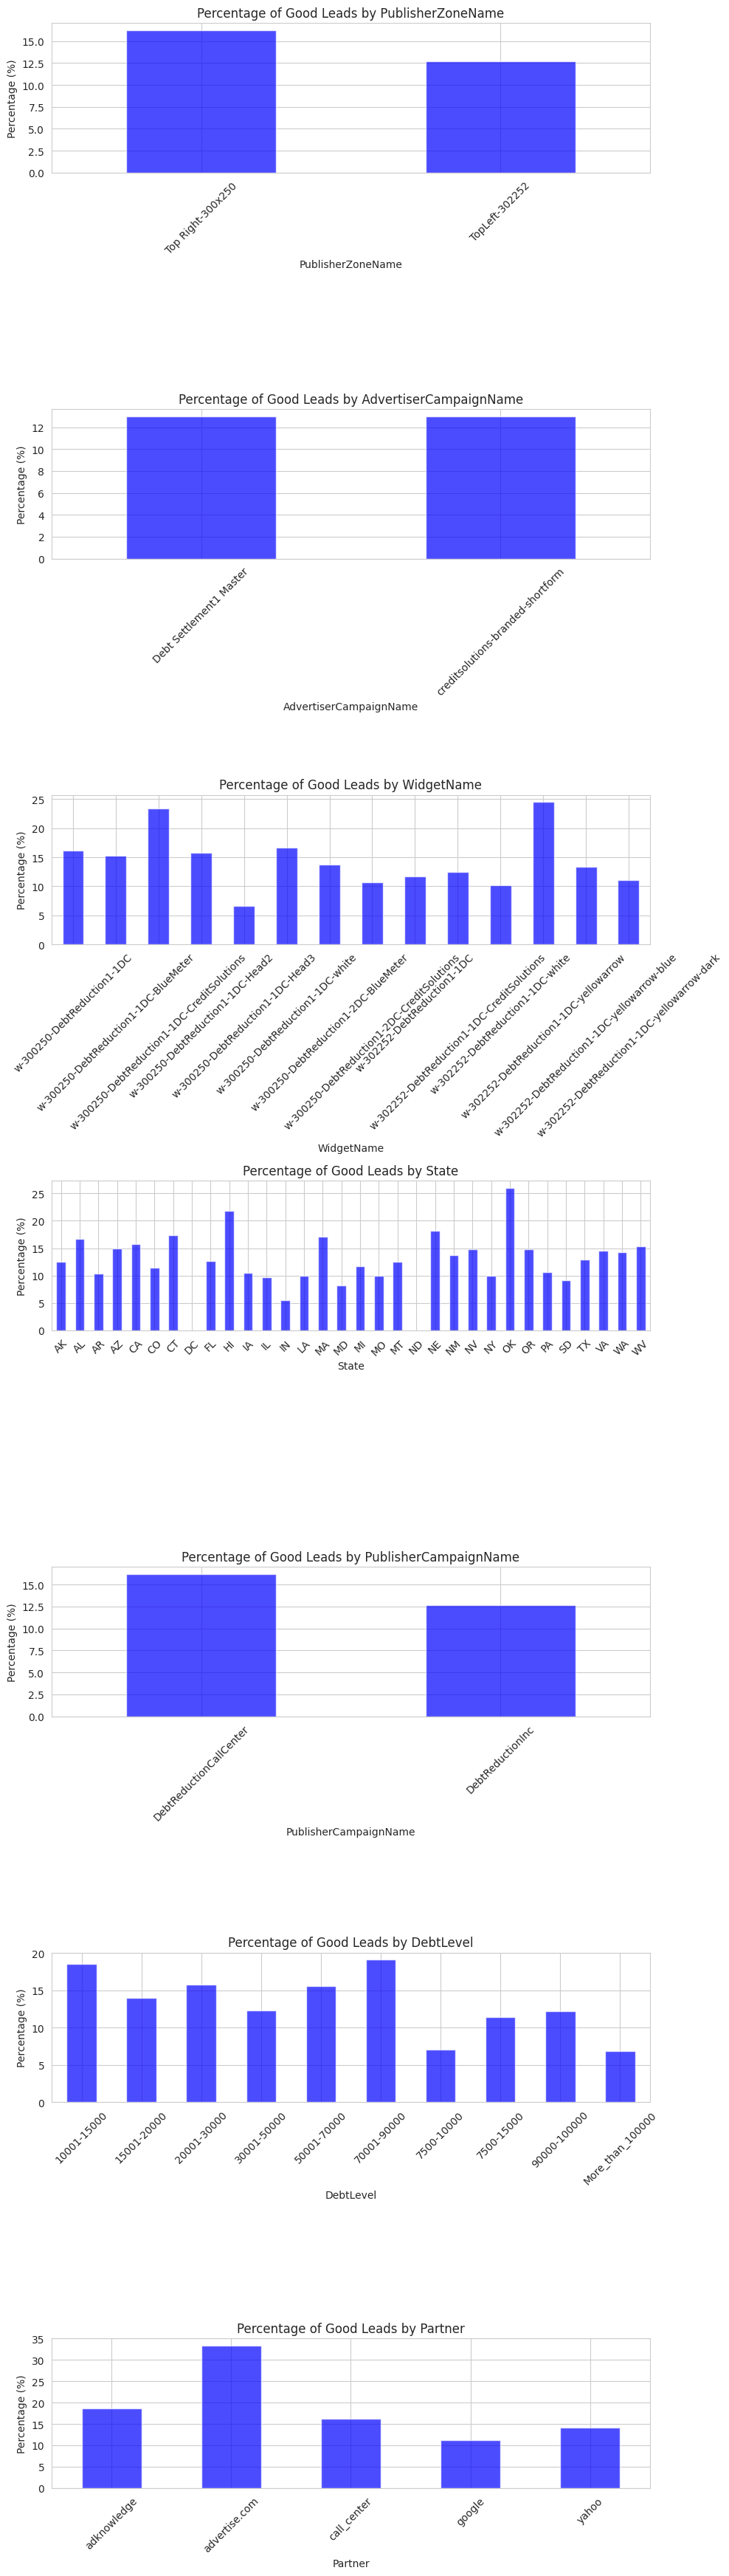

In [228]:


# Assuming df is your DataFrame
categorical_columns = [
    "PublisherZoneName",
    "AdvertiserCampaignName",
    "WidgetName",
    "State",
    "PublisherCampaignName",
    "DebtLevel",
    "Partner"
]

# Set style
sns.set_style("whitegrid")

# Create plots
fig, axes = plt.subplots(nrows=len(categorical_columns), ncols=1, figsize=(10, 5 * len(categorical_columns)))

for i, col in enumerate(categorical_columns):
    # Calculate the percentage of "Good" leads
    lead_quality_counts = df.groupby(col)["LeadQuality"].value_counts(normalize=True).unstack() * 100

    # Ensure "Good" category exists
    if "Good" in lead_quality_counts.columns:
        lead_quality_counts["Good"].plot(kind="bar", ax=axes[i], color="blue", alpha=0.7)
        axes[i].set_title(f"Percentage of Good Leads by {col}")
        axes[i].set_ylabel("Percentage (%)")
        axes[i].set_xlabel(col)
        axes[i].tick_params(axis='x', rotation=45)
    else:
        axes[i].axis("off")  # Hide the plot if there are no "Good" values

plt.tight_layout()
plt.show()


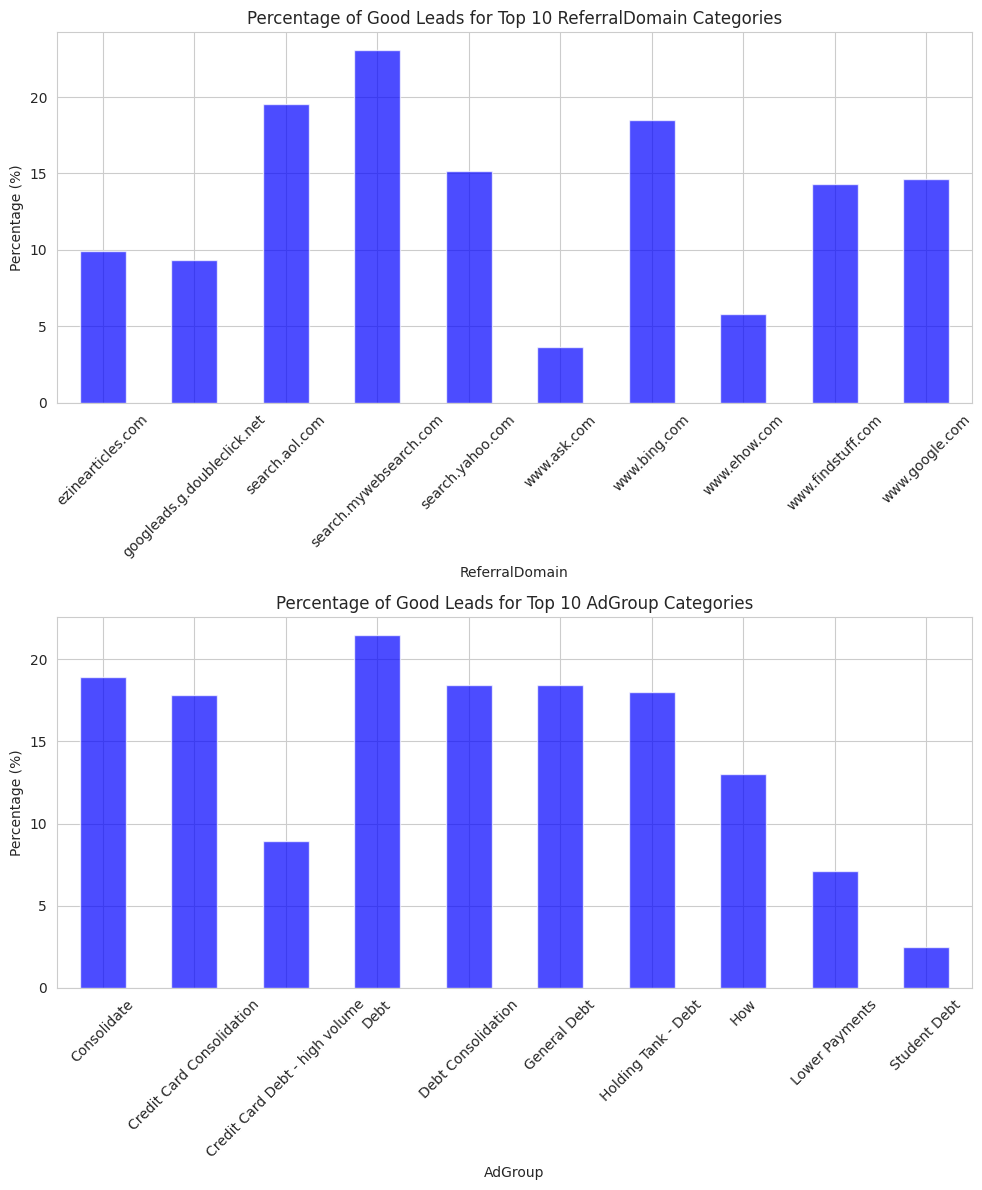

In [229]:

# Set style
sns.set_style("whitegrid")

# Columns to process
columns_to_filter = ["ReferralDomain", "AdGroup"]

# Create subplots
fig, axes = plt.subplots(nrows=len(columns_to_filter), ncols=1, figsize=(10, 6 * len(columns_to_filter)))

for i, col in enumerate(columns_to_filter):
    # Get the top 10 most frequent categories
    top_10_categories = df[col].value_counts().nlargest(10).index

    # Filter the DataFrame to keep only these categories
    df_filtered = df[df[col].isin(top_10_categories)]

    # Calculate the percentage of "Good" leads
    lead_quality_counts = df_filtered.groupby(col)["LeadQuality"].value_counts(normalize=True).unstack() * 100

    # Ensure "Good" category exists
    if "Good" in lead_quality_counts.columns:
        lead_quality_counts["Good"].plot(kind="bar", ax=axes[i], color="blue", alpha=0.7)
        axes[i].set_title(f"Percentage of Good Leads for Top 10 {col} Categories")
        axes[i].set_ylabel("Percentage (%)")
        axes[i].set_xlabel(col)
        axes[i].tick_params(axis='x', rotation=45)
    else:
        axes[i].axis("off")  # Hide the plot if there are no "Good" values

plt.tight_layout()
plt.show()


In [230]:
df = df[df["LeadQuality"].isin(["Good", "Bad"])]
orignal_df =df

#Where was the ad shown


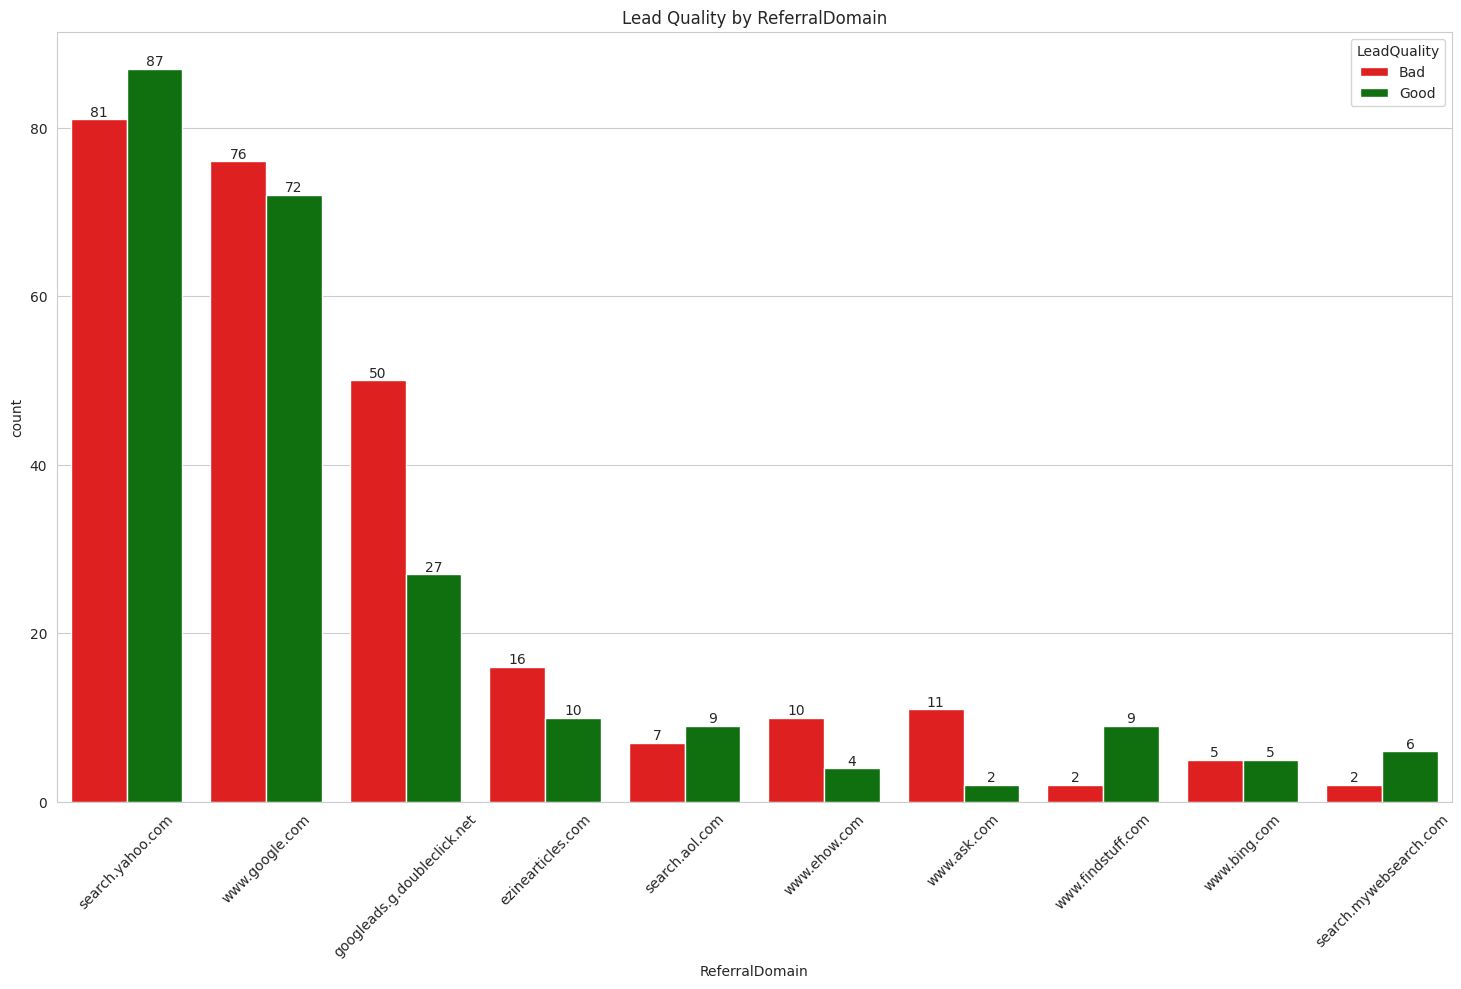

In [231]:
plt.figure(figsize=(18,10))
# Get only top 5 domains by modifying order parameter
ax = sns.countplot(x="ReferralDomain",
                  hue="LeadQuality",
                  data=df,
                  order=df["ReferralDomain"].value_counts().head(10).index,
                  palette=["red", "green"])

ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.xticks(rotation=45)
plt.title("Lead Quality by ReferralDomain")
plt.show()

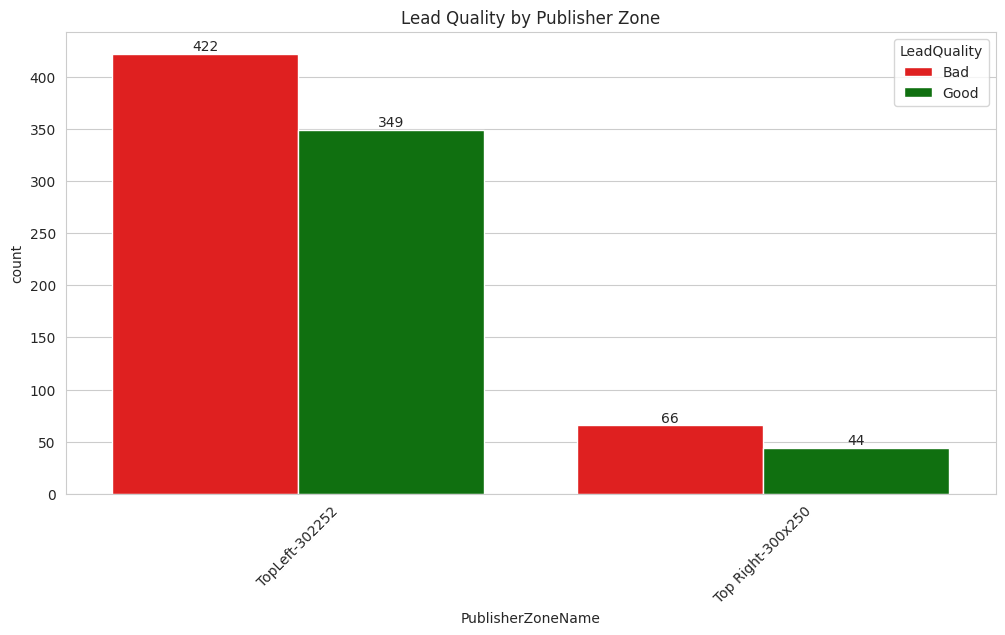

In [233]:

plt.figure(figsize=(12,6))
ax = sns.countplot(x="PublisherZoneName", hue="LeadQuality", data=df, order=df["PublisherZoneName"].value_counts().index, palette=["red", "green"])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.xticks(rotation=45)
plt.title("Lead Quality by Publisher Zone")
plt.show()

##What kind of ad

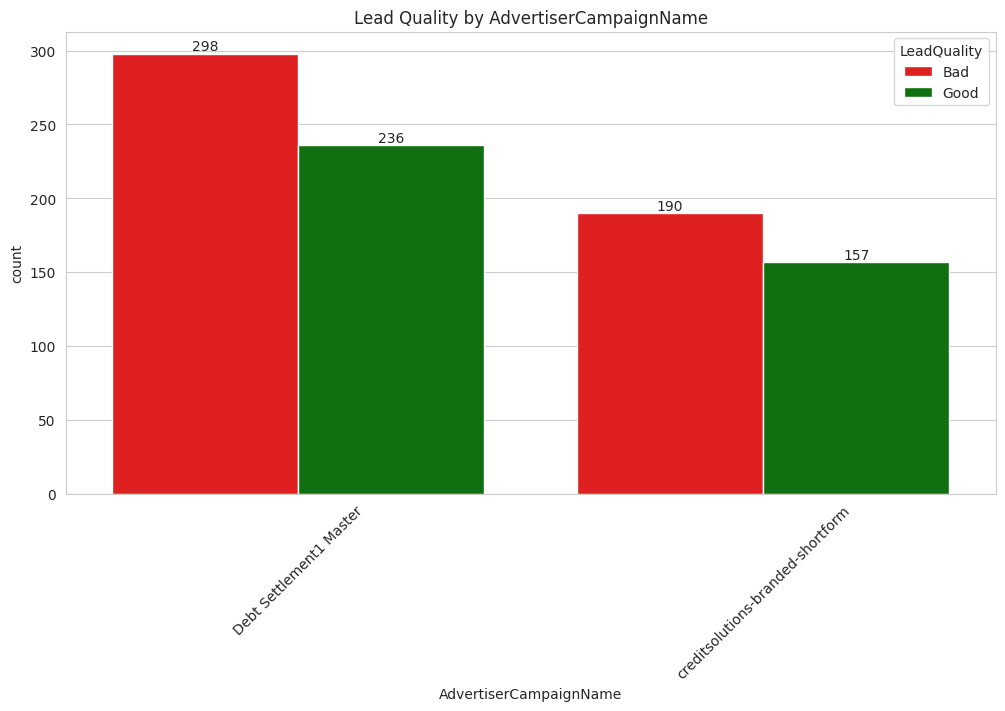

In [234]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x="AdvertiserCampaignName", hue="LeadQuality", data=df, order=df["AdvertiserCampaignName"].value_counts().index, palette=["red", "green"])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.xticks(rotation=45)
plt.title("Lead Quality by AdvertiserCampaignName")
plt.show()

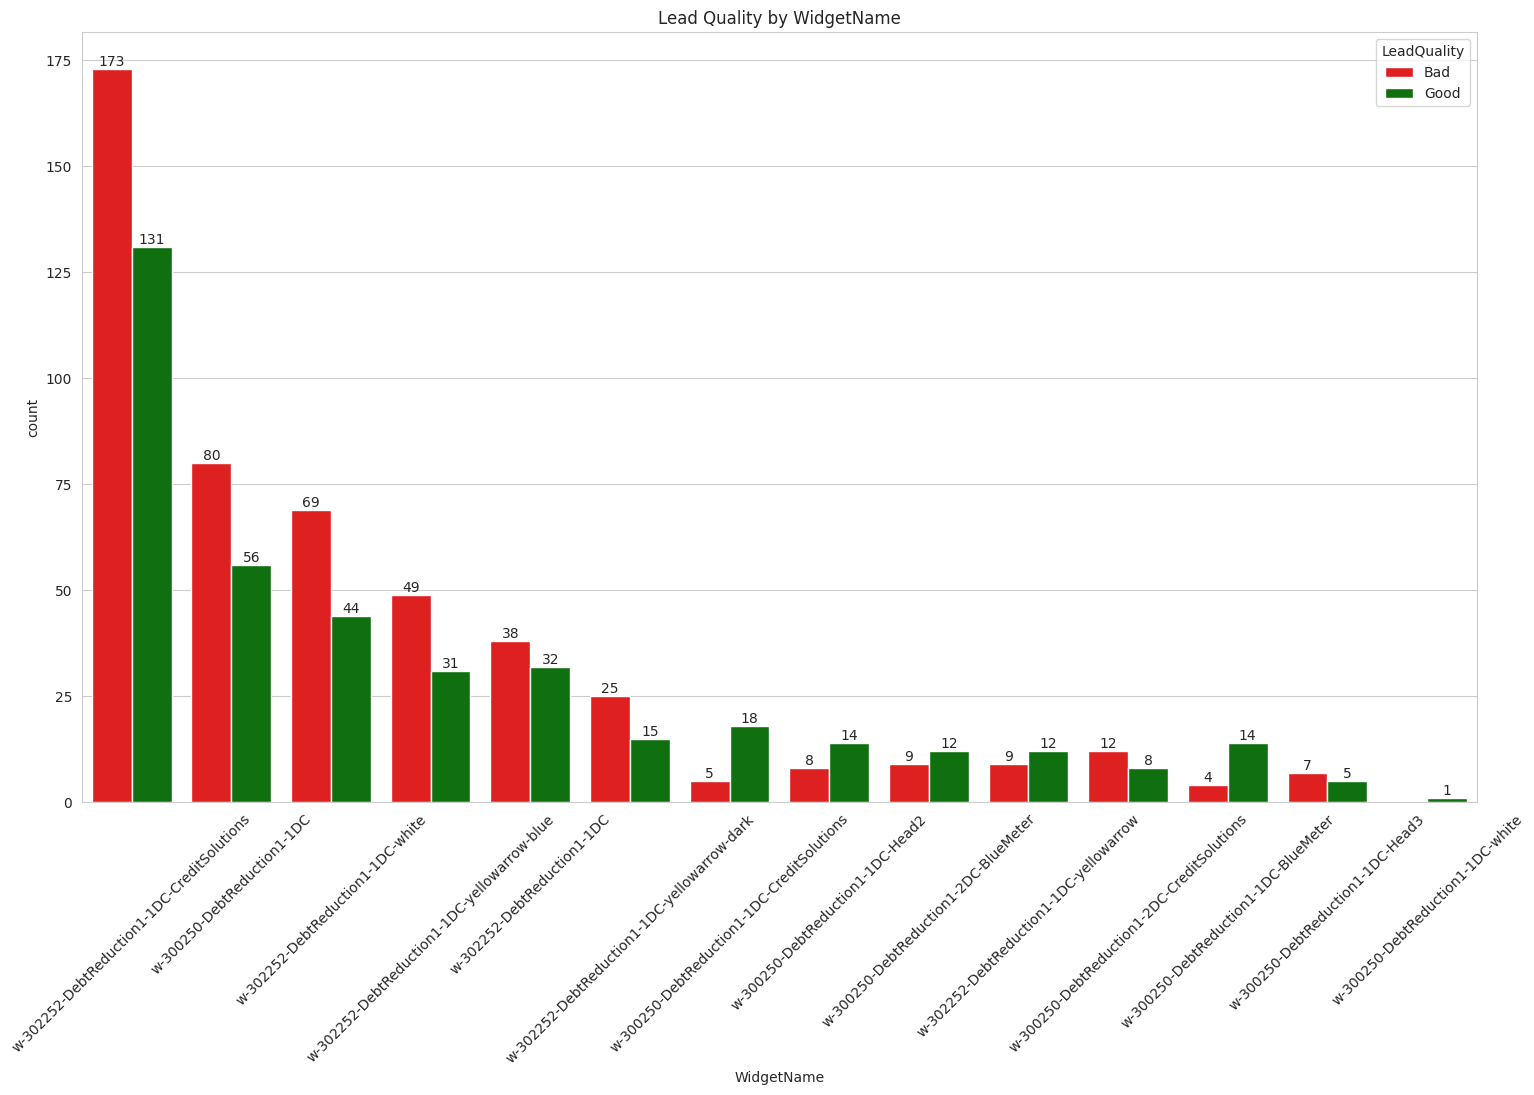

In [235]:
plt.figure(figsize=(18,10))
ax = sns.countplot(x="WidgetName", hue="LeadQuality", data=df, order=df["WidgetName"].value_counts().index, palette=["red", "green"])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.xticks(rotation=45)
plt.title("Lead Quality by WidgetName")
plt.show()

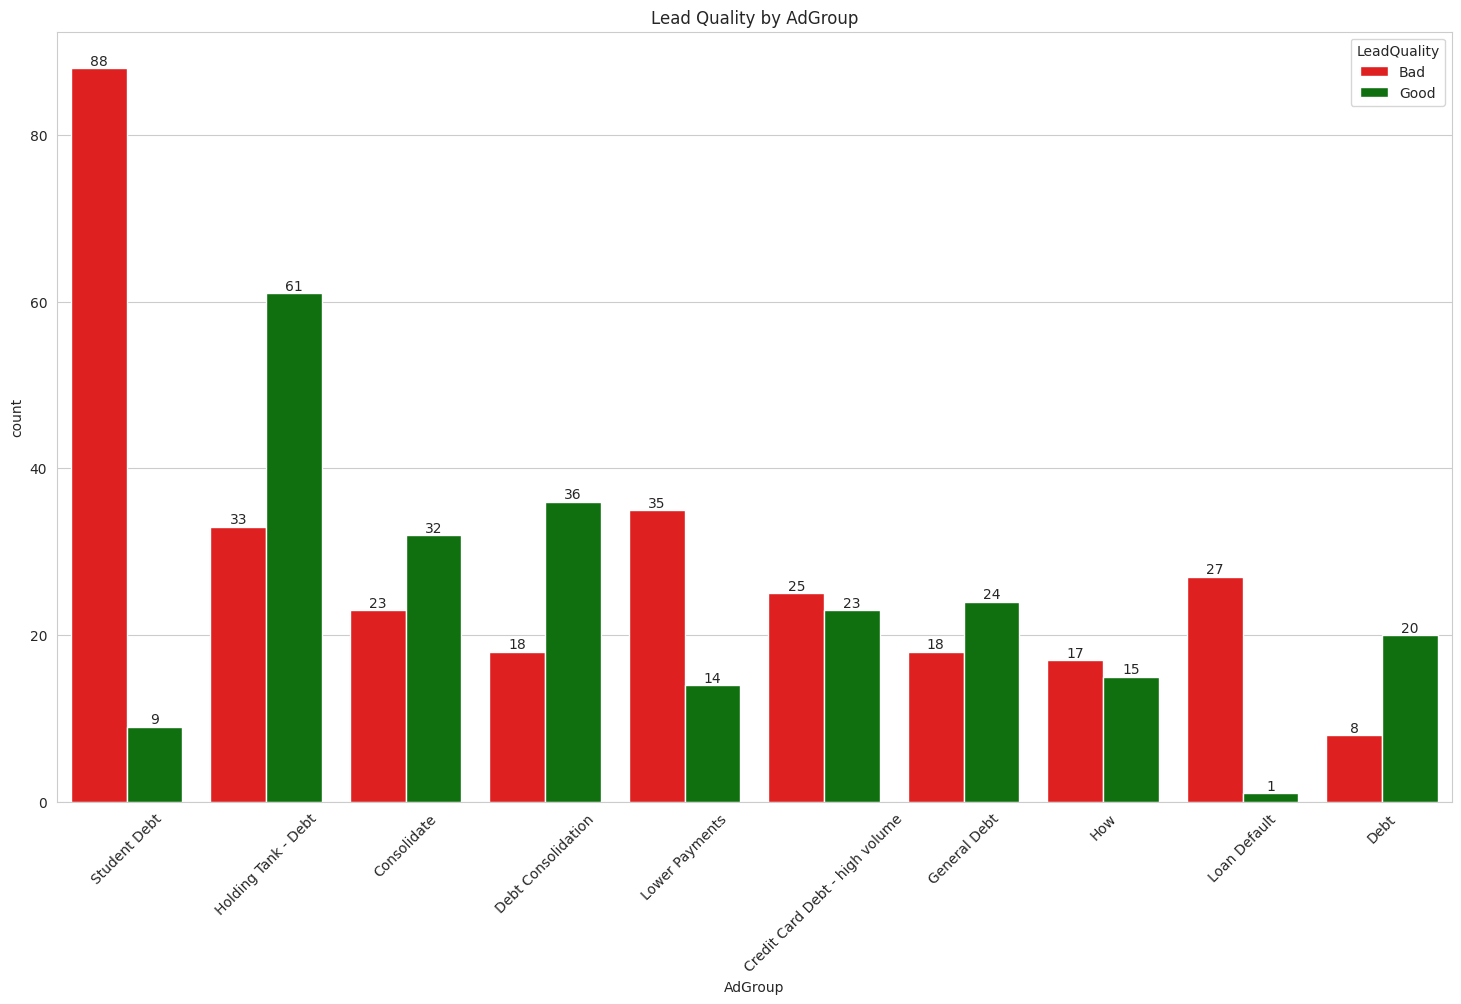

In [236]:
plt.figure(figsize=(18,10))
# Get only top 5 domains by modifying order parameter
ax = sns.countplot(x="AdGroup",
                  hue="LeadQuality",
                  data=df,
                  order=df["AdGroup"].value_counts().head(10).index,
                  palette=["red", "green"])

ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.xticks(rotation=45)
plt.title("Lead Quality by AdGroup")
plt.show()

##What kind of person


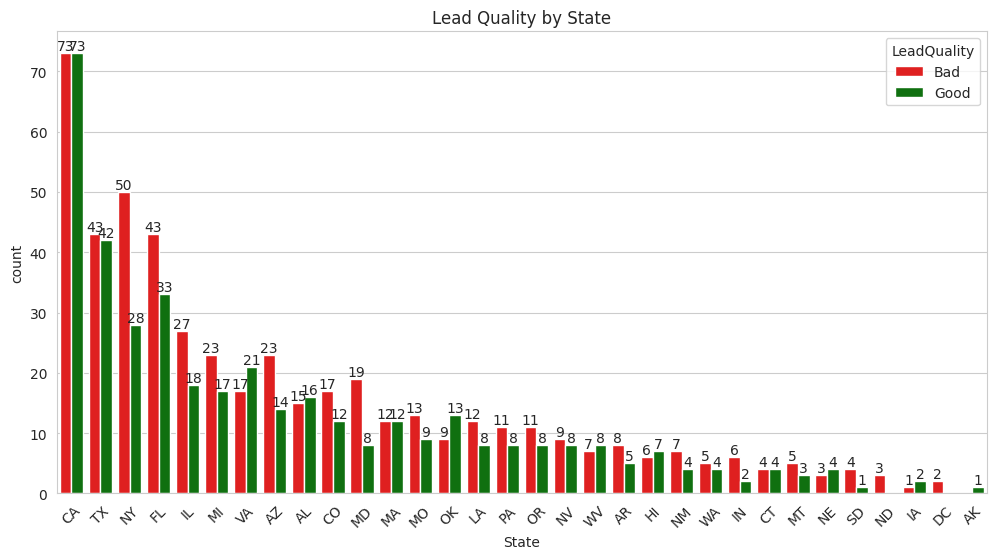

In [237]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x="State", hue="LeadQuality", data=df, order=df["State"].value_counts().index, palette=["red", "green"])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.xticks(rotation=45)
plt.title("Lead Quality by State")
plt.show()

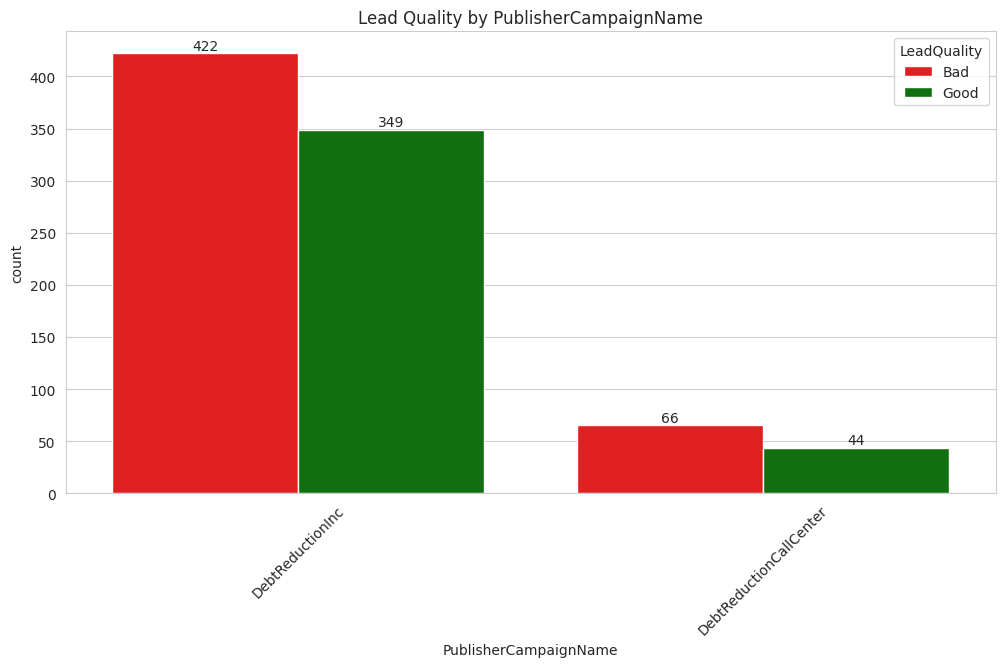

In [238]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x="PublisherCampaignName", hue="LeadQuality", data=df, order=df["PublisherCampaignName"].value_counts().index, palette=["red", "green"])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.xticks(rotation=45)
plt.title("Lead Quality by PublisherCampaignName")
plt.show()

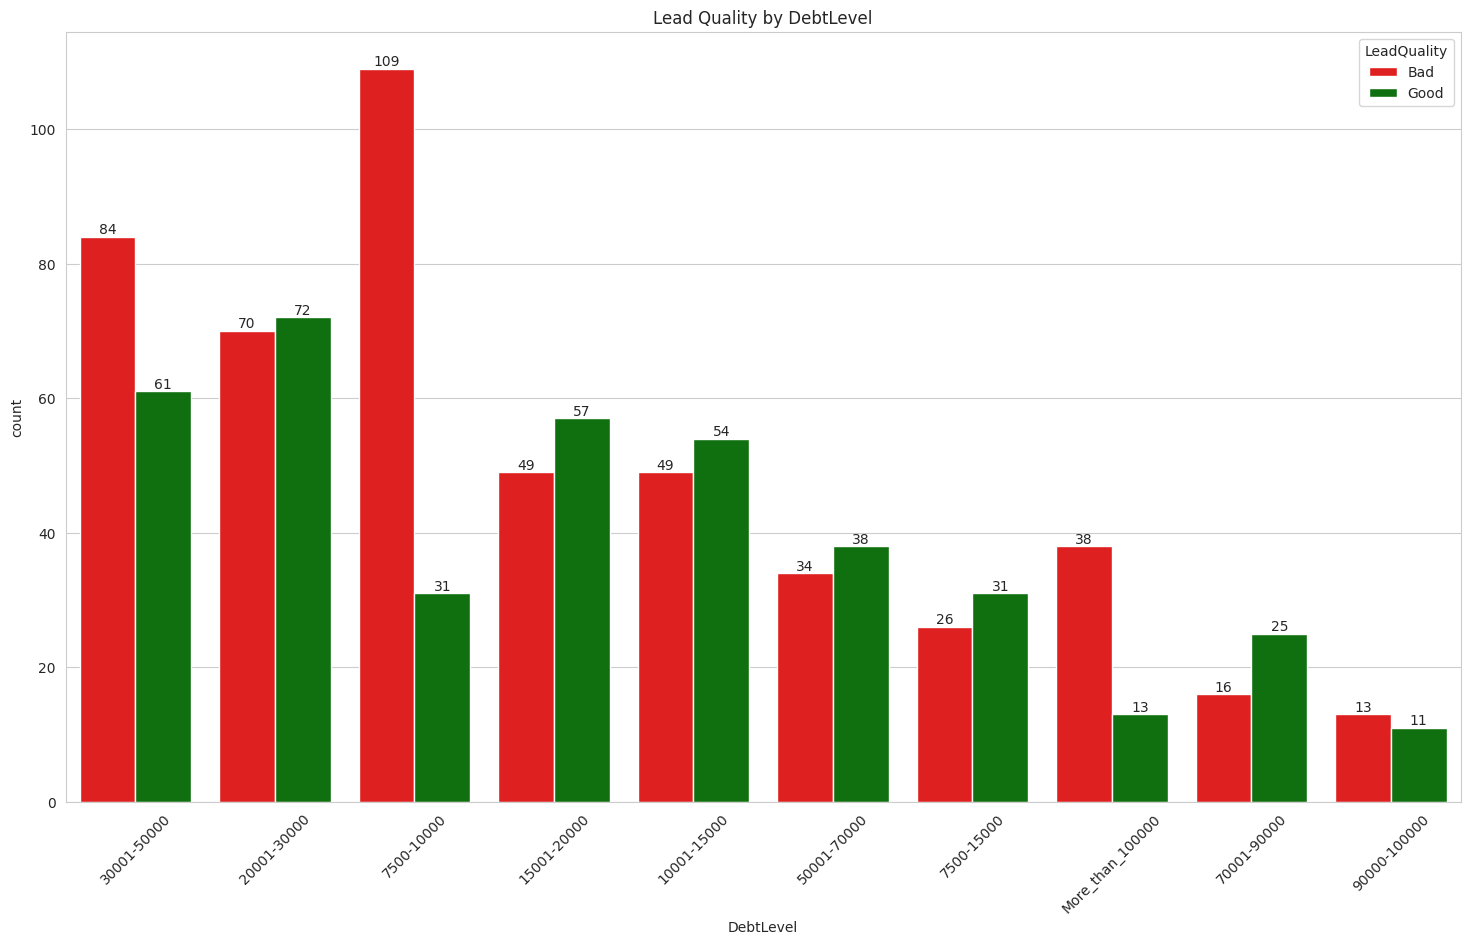

In [239]:
plt.figure(figsize=(18,10))
ax = sns.countplot(x="DebtLevel", hue="LeadQuality", data=df, order=df["DebtLevel"].value_counts().index, palette=["red", "green"])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.xticks(rotation=45)
plt.title("Lead Quality by DebtLevel")
plt.show()

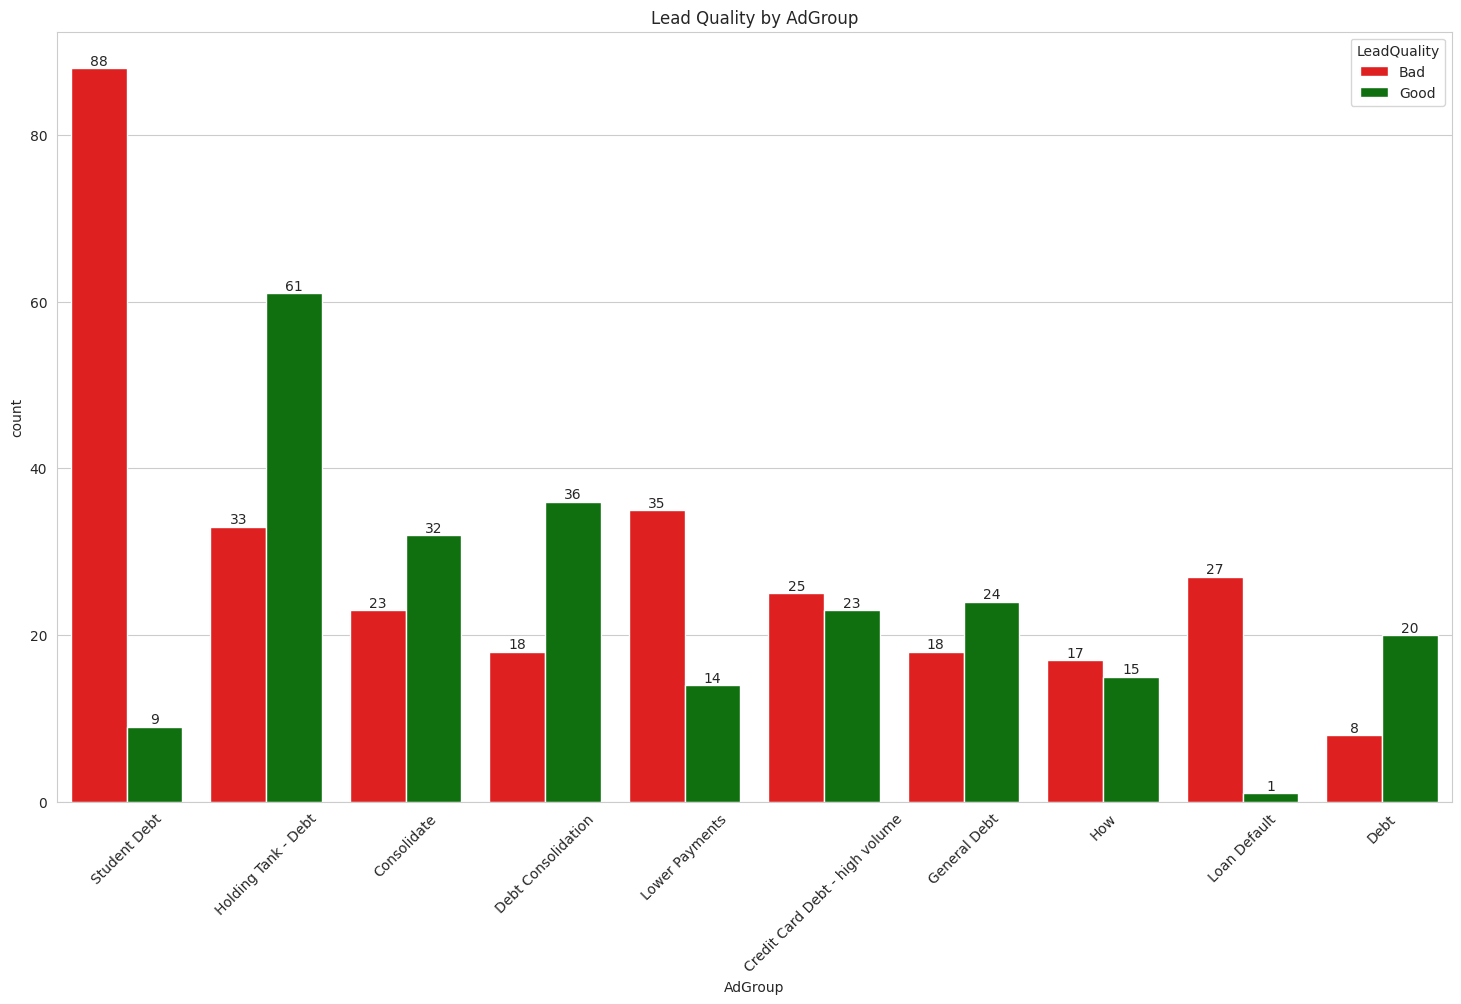

In [240]:
plt.figure(figsize=(18,10))
# Get only top 5 domains by modifying order parameter
ax = sns.countplot(x="AdGroup",
                  hue="LeadQuality",
                  data=df,
                  order=df["AdGroup"].value_counts().head(10).index,
                  palette=["red", "green"])

ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.xticks(rotation=45)
plt.title("Lead Quality by AdGroup")
plt.show()

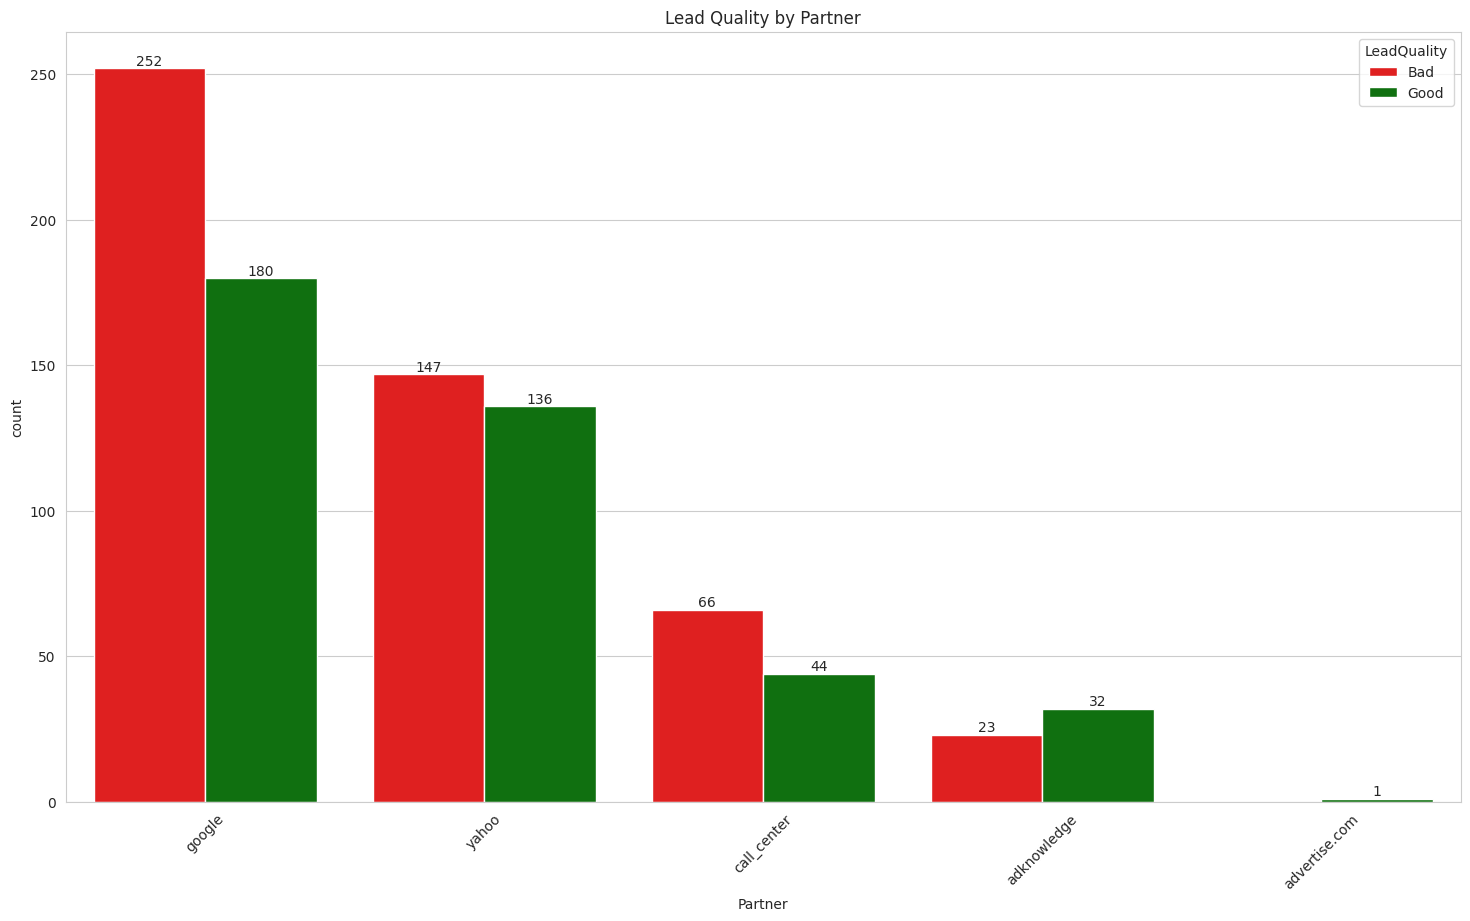

In [241]:
plt.figure(figsize=(18,10))
ax = sns.countplot(x="Partner", hue="LeadQuality", data=df, order=df["Partner"].value_counts().index, palette=["red", "green"])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.xticks(rotation=45)
plt.title("Lead Quality by Partner")
plt.show()

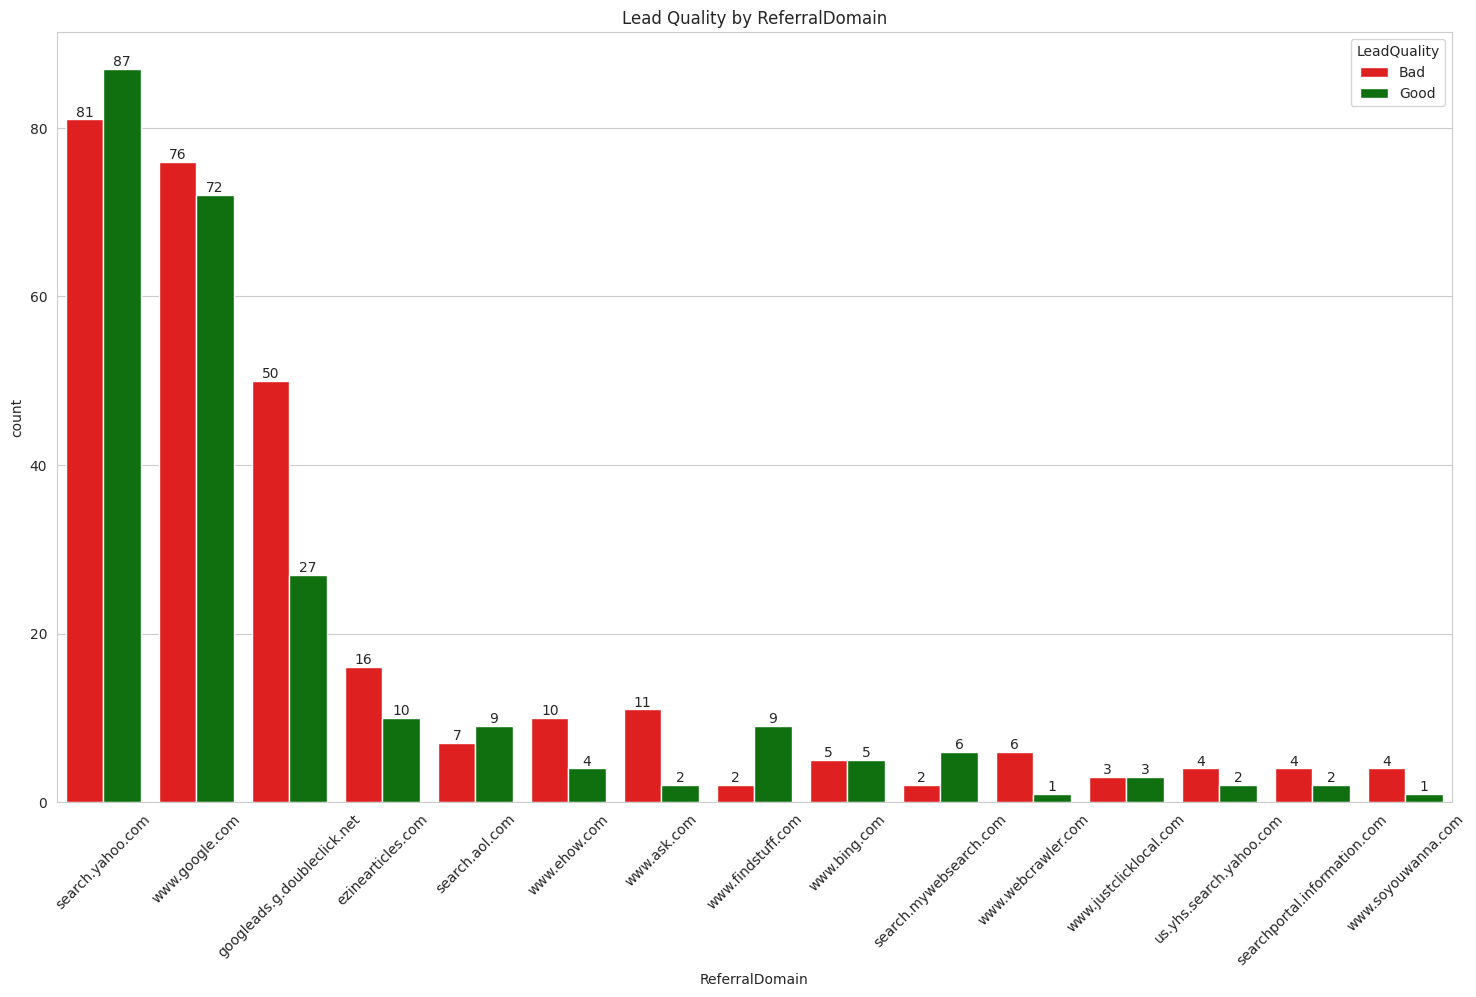

In [242]:
plt.figure(figsize=(18,10))
# Get only top 5 domains by modifying order parameter
ax = sns.countplot(x="ReferralDomain",
                  hue="LeadQuality",
                  data=df,
                  order=df["ReferralDomain"].value_counts().head(15).index,
                  palette=["red", "green"])

ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.xticks(rotation=45)
plt.title("Lead Quality by ReferralDomain")
plt.show()

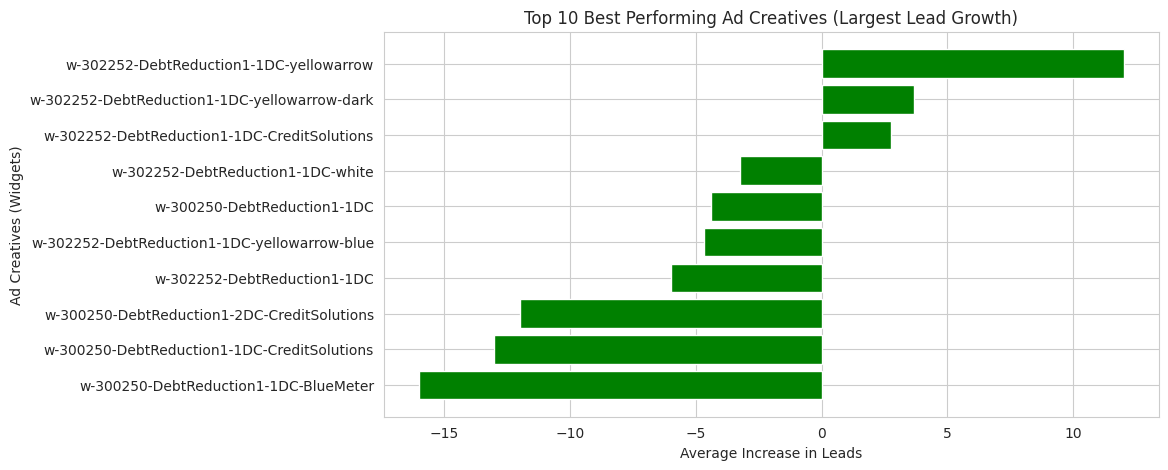

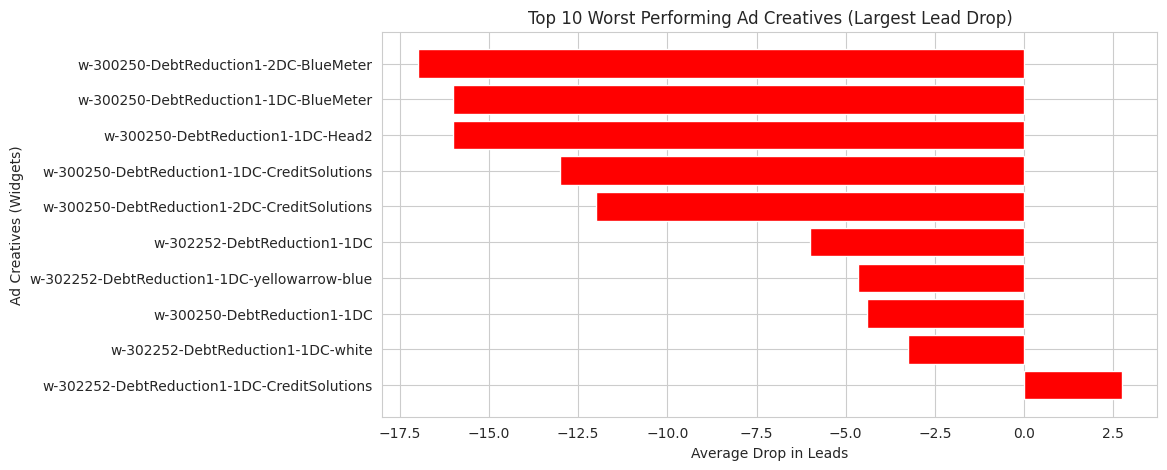

In [243]:
# Group by Month and WidgetName to count leads
widget_trend = orignal_df.groupby(['Month', 'WidgetName']).size().unstack()

# Compute the month-over-month difference
widget_growth = widget_trend.diff().mean().sort_values(ascending=False)

# Top 10 best-performing widgets (largest increase in leads)
top_10_best_widgets = widget_growth.nlargest(10)

# Top 10 worst-performing widgets (largest drop in leads)
top_10_worst_widgets = widget_growth.nsmallest(10)

# Plot for Best Widgets
plt.figure(figsize=(10, 5))
plt.barh(top_10_best_widgets.index, top_10_best_widgets.values, color='green')
plt.xlabel("Average Increase in Leads")
plt.ylabel("Ad Creatives (Widgets)")
plt.title("Top 10 Best Performing Ad Creatives (Largest Lead Growth)")
plt.gca().invert_yaxis()  # Invert y-axis for readability
plt.show()

# Plot for Worst Widgets
plt.figure(figsize=(10, 5))
plt.barh(top_10_worst_widgets.index, top_10_worst_widgets.values, color='red')
plt.xlabel("Average Drop in Leads")
plt.ylabel("Ad Creatives (Widgets)")
plt.title("Top 10 Worst Performing Ad Creatives (Largest Lead Drop)")
plt.gca().invert_yaxis()
plt.show()


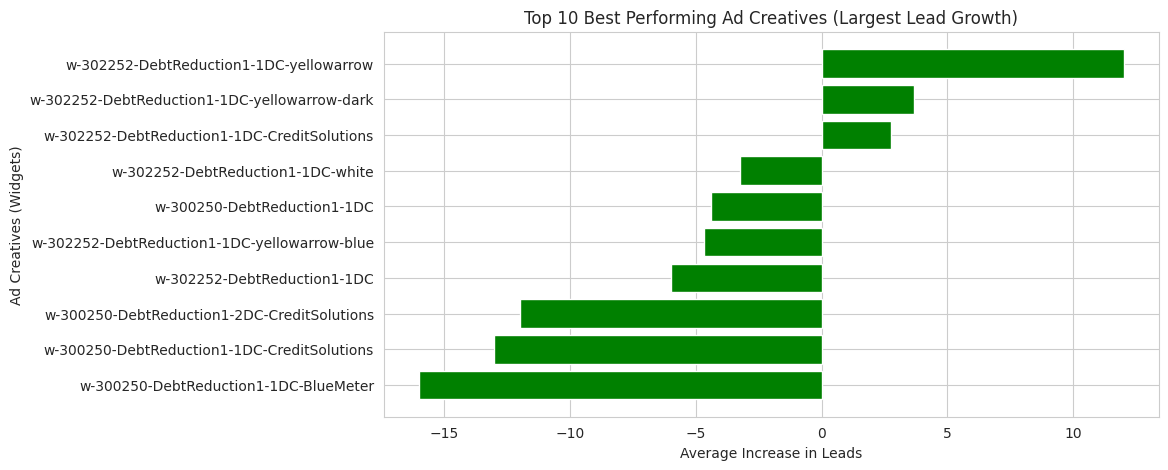

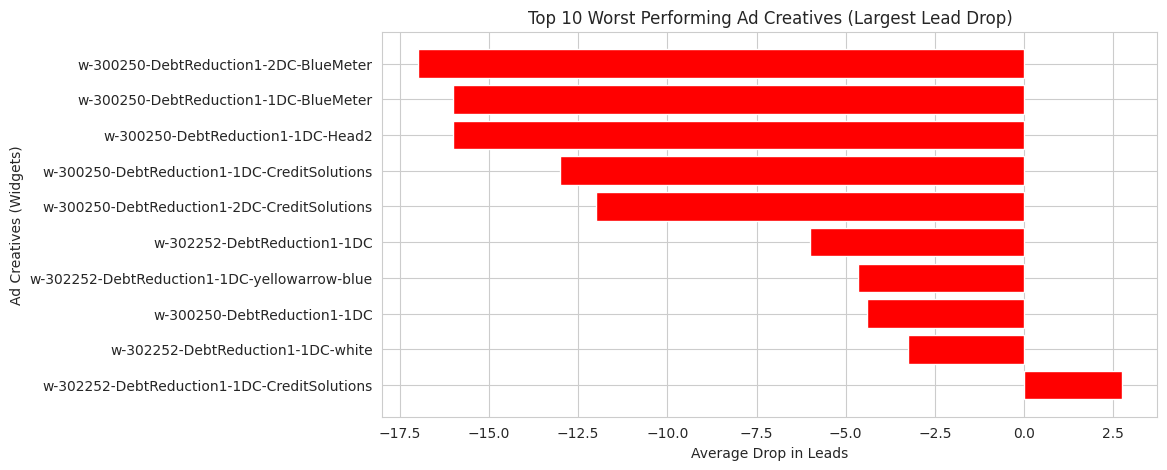

In [244]:
# Group by Month and WidgetName to count leads
widget_trend = df.groupby(['Month', 'WidgetName']).size().unstack()

# Compute the month-over-month difference
widget_growth = widget_trend.diff().mean().sort_values(ascending=False)

# Top 10 best-performing widgets (largest increase in leads)
top_10_best_widgets = widget_growth.nlargest(10)

# Top 10 worst-performing widgets (largest drop in leads)
top_10_worst_widgets = widget_growth.nsmallest(10)

# Plot for Best Widgets
plt.figure(figsize=(10, 5))
plt.barh(top_10_best_widgets.index, top_10_best_widgets.values, color='green')
plt.xlabel("Average Increase in Leads")
plt.ylabel("Ad Creatives (Widgets)")
plt.title("Top 10 Best Performing Ad Creatives (Largest Lead Growth)")
plt.gca().invert_yaxis()  # Invert y-axis for readability
plt.show()

# Plot for Worst Widgets
plt.figure(figsize=(10, 5))
plt.barh(top_10_worst_widgets.index, top_10_worst_widgets.values, color='red')
plt.xlabel("Average Drop in Leads")
plt.ylabel("Ad Creatives (Widgets)")
plt.title("Top 10 Worst Performing Ad Creatives (Largest Lead Drop)")
plt.gca().invert_yaxis()
plt.show()

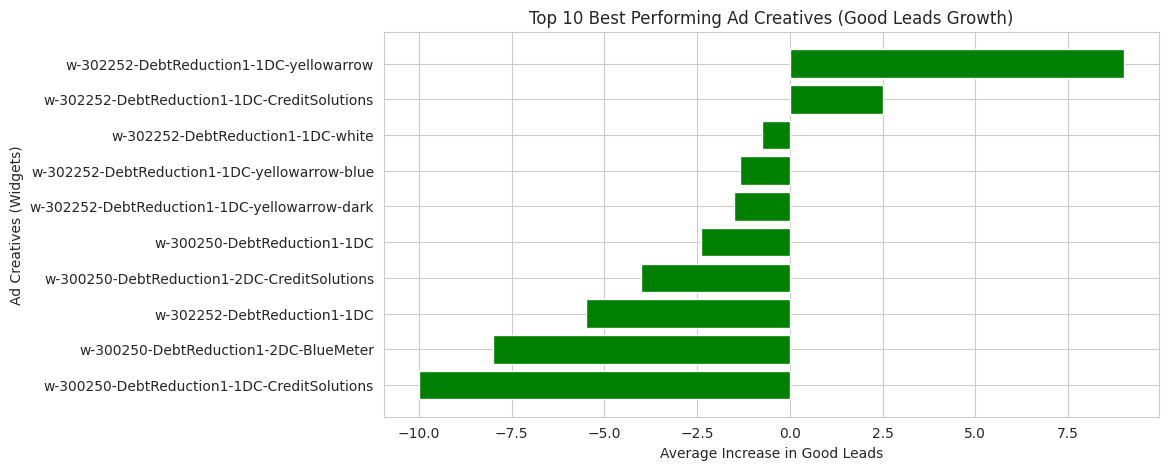

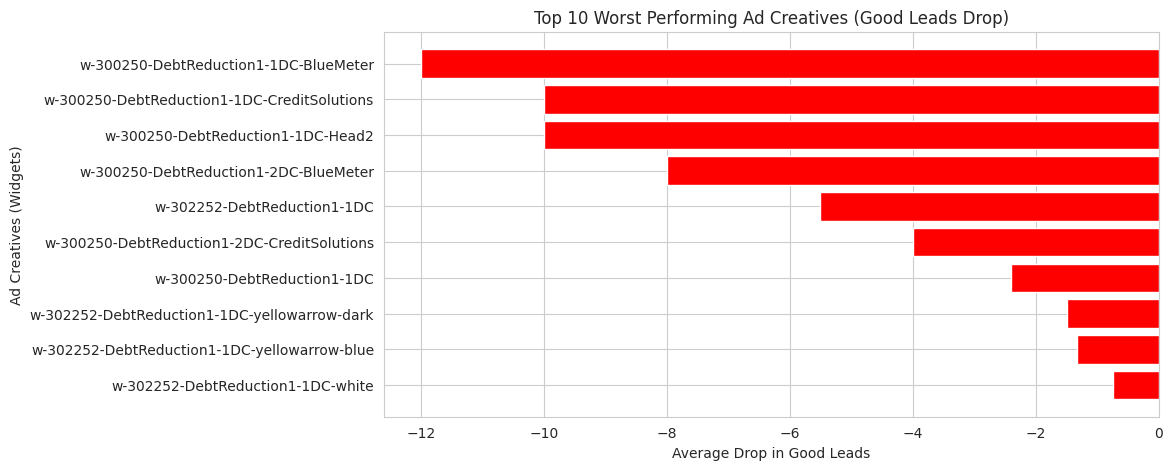

In [245]:
import matplotlib.pyplot as plt

# Filter only "Good Quality Lead"
good_leads_df = df[df['LeadQuality'] == 'Good']

# Group by Month and WidgetName to count good leads
widget_trend = good_leads_df.groupby(['Month', 'WidgetName']).size().unstack()

# Compute the month-over-month difference
widget_growth = widget_trend.diff().mean().sort_values(ascending=False)

# Top 10 best-performing widgets (largest increase in good leads)
top_10_best_widgets = widget_growth.nlargest(10)

# Top 10 worst-performing widgets (largest drop in good leads)
top_10_worst_widgets = widget_growth.nsmallest(10)

# Plot for Best Widgets
plt.figure(figsize=(10, 5))
plt.barh(top_10_best_widgets.index, top_10_best_widgets.values, color='green')
plt.xlabel("Average Increase in Good Leads")
plt.ylabel("Ad Creatives (Widgets)")
plt.title("Top 10 Best Performing Ad Creatives (Good Leads Growth)")
plt.gca().invert_yaxis()  # Invert y-axis for readability
plt.show()

# Plot for Worst Widgets
plt.figure(figsize=(10, 5))
plt.barh(top_10_worst_widgets.index, top_10_worst_widgets.values, color='red')
plt.xlabel("Average Drop in Good Leads")
plt.ylabel("Ad Creatives (Widgets)")
plt.title("Top 10 Worst Performing Ad Creatives (Good Leads Drop)")
plt.gca().invert_yaxis()
plt.show()


Text(0.5, 1.0, 'Lead Distribution by Referral Domain and Widget Name (Top 15 Most Frequent Referral Domains)')

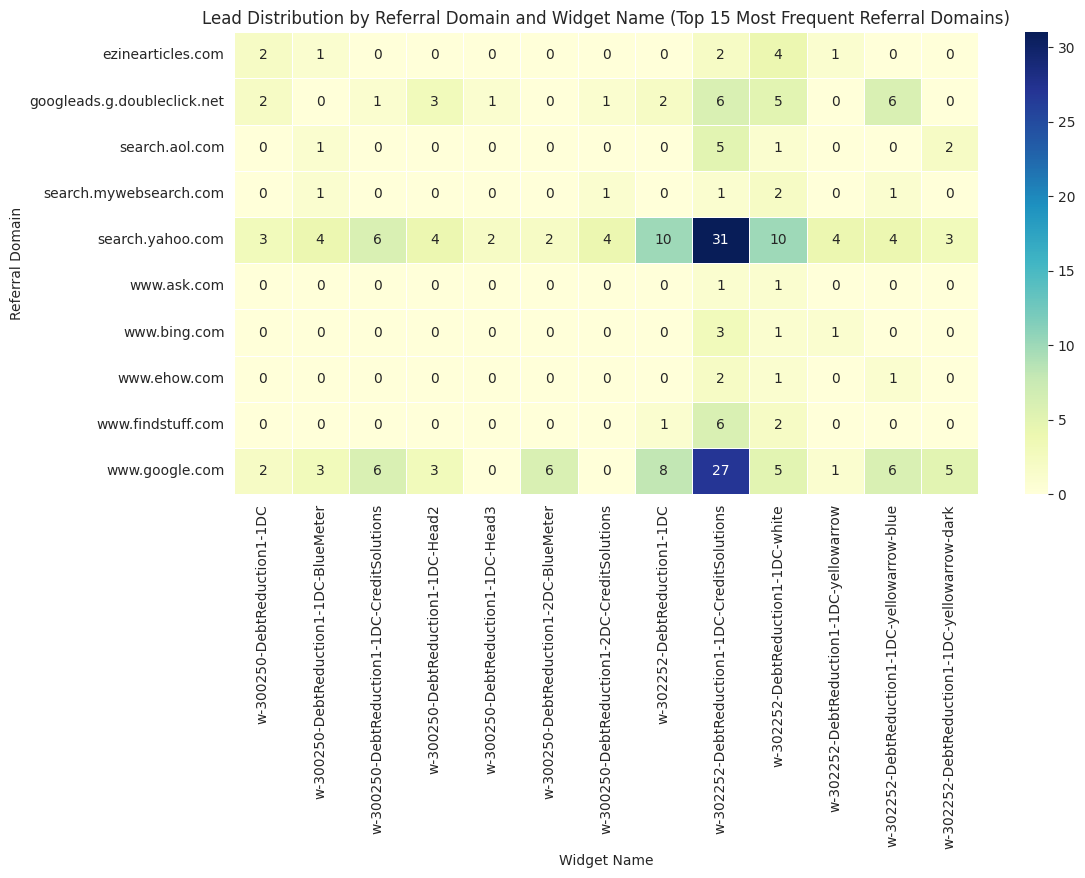

In [246]:
# Get the top 15 most frequent referral domains
top_referral_domains = df['ReferralDomain'].value_counts().head(10).index

good_leads_df = df[df['LeadQuality'] == 'Good']
df = good_leads_df
# Filter the dataset to include only the top 15 referral domains
filtered_df = df[df['ReferralDomain'].isin(top_referral_domains)]

# Create a pivot table (matrix) of ReferralDomain vs WidgetName with lead counts
matrix = filtered_df.pivot_table(index='ReferralDomain', columns='WidgetName', aggfunc='size', fill_value=0)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(matrix, cmap="YlGnBu", annot=True, fmt="d", linewidths=0.5)

# Labels and title
plt.xlabel("Widget Name")
plt.ylabel("Referral Domain")
plt.title("Lead Distribution by Referral Domain and Widget Name (Top 15 Most Frequent Referral Domains)")

# Show plot

Text(0.5, 1.0, 'Lead Distribution by Referral Domain and Widget Name (Top 15 Most Frequent Referral Domains)')

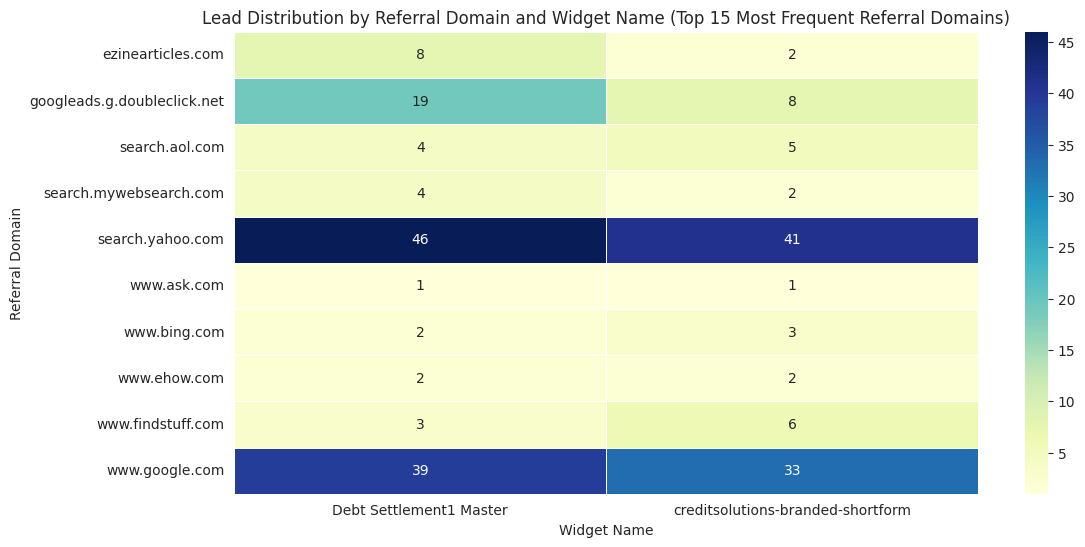

In [247]:
df =orignal_df
top_referral_domains = df['ReferralDomain'].value_counts().head(10).index

good_leads_df = df[df['LeadQuality'] == 'Good']
df = good_leads_df
# Filter the dataset to include only the top 15 referral domains
filtered_df = df[df['ReferralDomain'].isin(top_referral_domains)]

# Create a pivot table (matrix) of ReferralDomain vs WidgetName with lead counts
matrix = filtered_df.pivot_table(index='ReferralDomain', columns='AdvertiserCampaignName', aggfunc='size', fill_value=0)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(matrix, cmap="YlGnBu", annot=True, fmt="d", linewidths=0.5)

# Labels and title
plt.xlabel("Widget Name")
plt.ylabel("Referral Domain")
plt.title("Lead Distribution by Referral Domain and Widget Name (Top 15 Most Frequent Referral Domains)")

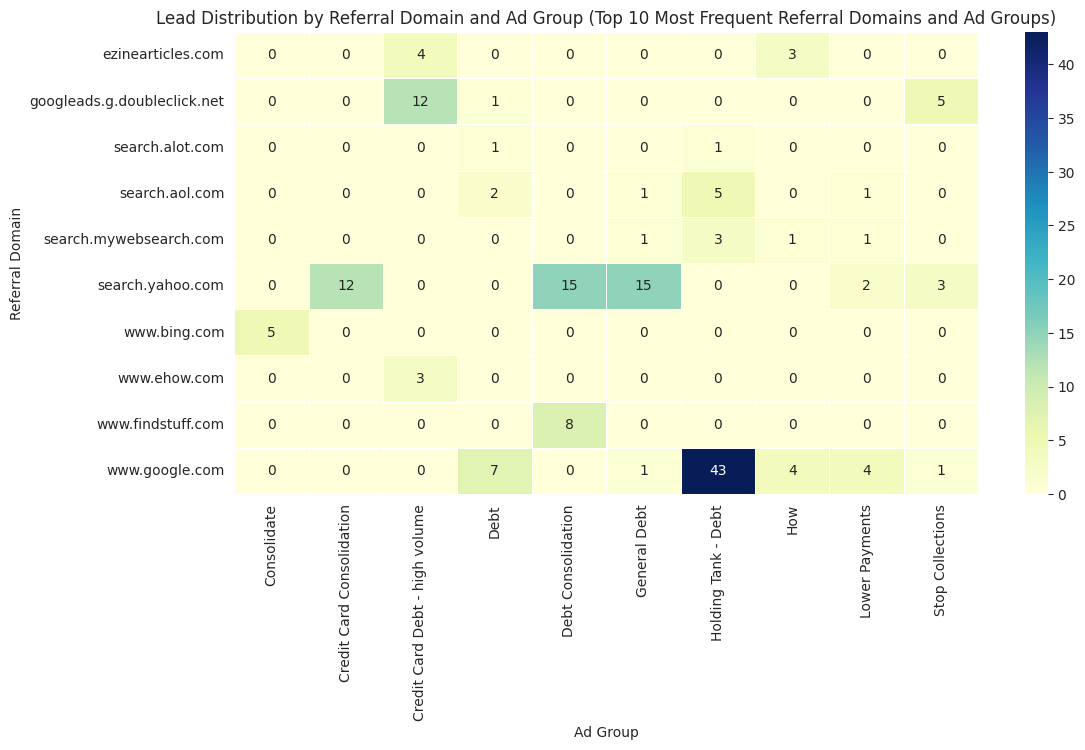

In [248]:
top_referral_domains = df['ReferralDomain'].value_counts().head(10).index
top_ad_groups = df['AdGroup'].value_counts().head(10).index

good_leads_df = df[df['LeadQuality'] == 'Good']
df = good_leads_df
# Filter the dataset to include only rows with the top 10 referral domains and top 10 ad groups
filtered_df = df[df['ReferralDomain'].isin(top_referral_domains) & df['AdGroup'].isin(top_ad_groups)]

# Create a pivot table (matrix) of ReferralDomain vs AdGroup with lead counts
matrix = filtered_df.pivot_table(index='ReferralDomain', columns='AdGroup', aggfunc='size', fill_value=0)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(matrix, cmap="YlGnBu", annot=True, fmt="d", linewidths=0.5)

# Labels and title
plt.xlabel("Ad Group")
plt.ylabel("Referral Domain")
plt.title("Lead Distribution by Referral Domain and Ad Group (Top 10 Most Frequent Referral Domains and Ad Groups)")
plt.show()

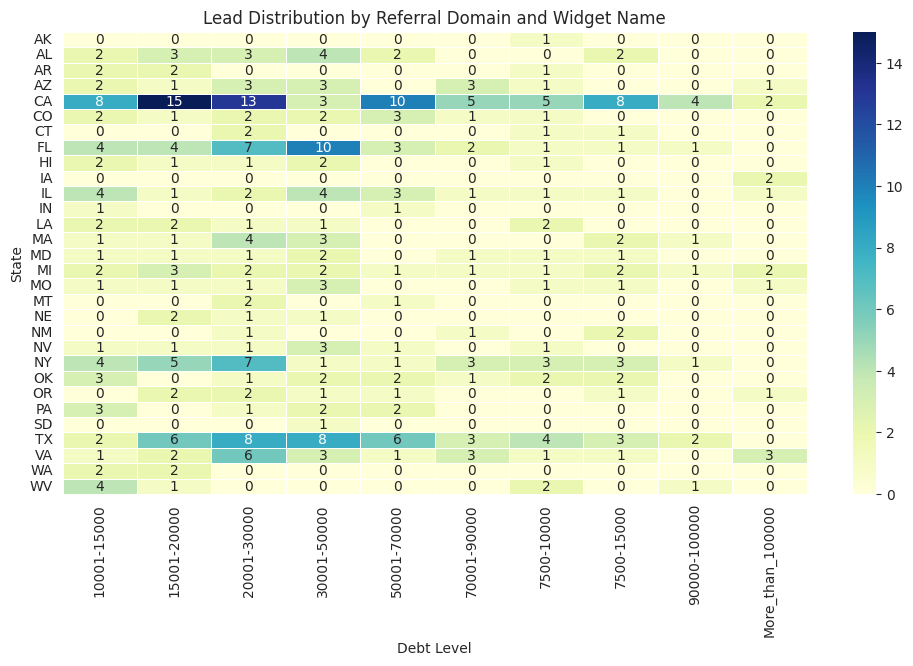

In [249]:
good_leads_df = df[df['LeadQuality'] == 'Good']

# Create a pivot table (matrix) of ReferralDomain vs WidgetName with lead counts
matrix = good_leads_df.pivot_table(index='State', columns='DebtLevel', aggfunc='size', fill_value=0)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(matrix, cmap="YlGnBu", annot=True, fmt="d", linewidths=0.5)

# Labels and title
plt.xlabel("Debt Level")
plt.ylabel("State")
plt.title("Lead Distribution by Referral Domain and Widget Name")

# Show plot
plt.show()

Model Accuracy: 0.8645

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       532
           1       0.24      0.05      0.09        73

    accuracy                           0.86       605
   macro avg       0.56      0.52      0.51       605
weighted avg       0.80      0.86      0.83       605


Feature Importances:
 State                    0.257194
DebtLevel                0.175612
ReferralDomain           0.169913
WidgetName               0.153251
MarketingCampaign        0.076249
PhoneScore               0.064175
AddressScore             0.057344
Partner                  0.041556
PublisherCampaignName    0.002653
PublisherZoneName        0.002052
dtype: float64


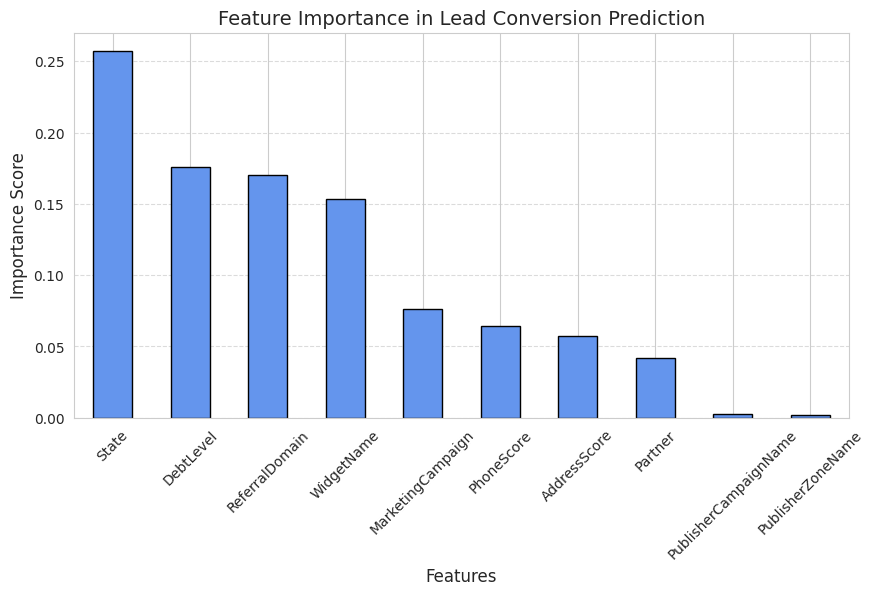

In [250]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Load the dataset
file_path = "/content/Analyst case study dataset 1.xls"
xls = pd.ExcelFile(file_path)
sheet1_df = xls.parse('Sheet1')
sheet1_df['LeadQuality'] = sheet1_df['CallStatus'].apply(lambda x: 'Unknown' if x == 'Unknown'
                                           else 'Good Quality Lead' if x in ['Closed', 'EP Confirmed', 'EP Received', 'EP Sent']
                                           else 'Bad Quality Lead')

# Data Preparation: Selecting Relevant Features
features = ['WidgetName', 'PublisherZoneName', 'PublisherCampaignName',
            'AddressScore', 'PhoneScore', 'DebtLevel', 'Partner', 'ReferralDomain',
            'MarketingCampaign', 'State']

# Target Variable: "Closed" vs Other Statuses
sheet1_df['Converted'] = sheet1_df['LeadQuality'].apply(lambda x: 1 if x == 'Good Quality Lead' else 0)

# Encode Categorical Variables
label_encoders = {}
for col in features:
    le = LabelEncoder()
    sheet1_df[col] = le.fit_transform(sheet1_df[col].astype(str))
    label_encoders[col] = le

# Splitting dataset into training and test sets
X = sheet1_df[features]
y = sheet1_df['Converted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training: RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Model Predictions
y_pred = model.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Feature Importance Analysis
feature_importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

# Display Results
print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)
print("\nFeature Importances:\n", feature_importances)

# Visualizing Feature Importance
plt.figure(figsize=(10, 5))
feature_importances.plot(kind='bar', color='cornflowerblue', edgecolor='black')
plt.title("Feature Importance in Lead Conversion Prediction", fontsize=14)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Importance Score", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
